# Setup

In [83]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
import bbknn
import re
import httplib2 as http
import json

In [84]:
sc.settings.verbosity = 0            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map = 'Reds', figsize = (5, 5),dpi_save=300)

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.8.1 pandas==1.4.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [85]:
# Using the list of phenotypes (see notebook pt1), make a dictionary grouping them. Have remoced partial strings in case these are inappropraitely matched
phenotype_dict={
    'Heterotaxy':['Heterotaxy','Dextrocardia'],
    'ASD':['ASD','Atrial septal defect','Patent foramen ovale'],
    'VSD':['VSD','Ventricular septal defect'],
    'AVSD':['AVSD','Atrioventricular septal defect'],
    'Malformation of outflow tracts':['Truncus arteriosus','Malformation of outflow tracts','Fallot','fallot','Double outlet right ventricle','Pentalogy of fallot','Transposition of the great arteries','Transposition of the great vessels',],
    'Functional single ventricle':['Functional single ventricle','Double-inlet left ventricle','Hypoplastic left heart syndrome','Hypoplastic right ventricle','Hypoplastic rv'],
#    'Obstructive lesions':['Obstructive lesions','alv','stenosis'], # removed because I don't know how to define this term
    'Cardiomyopathy':['Cardiomyopathy'],
    'DCM':['DCM','Dilated cardiomyopathy'],
    'HCM':['HCM','Hypertrophic cardiomyopathy'],
    'LVNC':['LVNC','Left ventricular noncompaction'],
    'Venous anomaly':['Total anomalous pulmonary venous return','Pulmonary vein stenosis','Partial anomalous pulmonary venous return','Persistent left superior vena cava'],
    'Pulmonary artery':['Dilatation of the pulmonary trunk','Hypoplastic left pulmonary artery','Pulmonary artery dysplasia and hypoplasia','Pulmonary atresia','Pulmonary trunk and pulmonary artery absence'],
    'Aortic arch':['Right aortic arch','Patent ductus arteriosus','Ductus arteriosus','Coarctation of the aorta','Interrupted aortic arch','Lsvc and left pulmonary artery arising from the ductus arteriosus'],
    'Aorta':['Aberrant supraclavicular artery','Anomalous right subclavian artery','Aortic aneurysm','Aortic hypoplasia'],
    'Coronary anomaly':['Anomalous left coronary artery from the pulmonary artery','Coronary artery anomaly'],
    'VA valves':['Pulmonic stenosis','Absent pulmonary valve','Bicuspid aortic valve', 'Aortic stenosis','Dysplastic pulmonary valve','Pulmonary stenosis'],
    'AV valves':['Dysplastic mitral valve','Dysplastic tricuspid valve',"Ebstein's anomaly",'Mitral atresia','Mitral stenosis','Mitral valve dysplasia','Tricuspid atresia','Tricuspid stenosis','Tricuspid valve atresia','Tricuspid valve dysplasia']
}

# Import Mendelian genes

In [86]:
df=pd.read_csv('/home/jovyan/data/combined_tidied_disease_gene_with_phenotype_annotation.csv')
df=df.set_index('Unnamed: 0')
df

,TF,source,phenotype_Heterotaxy,phenotype_ASD,phenotype_VSD,phenotype_AVSD,phenotype_Malformation of outflow tracts,phenotype_Functional single ventricle,phenotype_Cardiomyopathy,phenotype_DCM,phenotype_HCM,phenotype_LVNC,phenotype_Venous anomaly,phenotype_Pulmonary artery,phenotype_Aortic arch,phenotype_Aorta,phenotype_Coronary anomaly,phenotype_VA valves,phenotype_AV valves,phenotype
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
ABL1,1,CHDgene,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Atrial septal defect,Ventricular septal defect"
ACTC1,0,CHDgene,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Atrial septal defect,Ventricular septal defect"
ACVR1,0,CHDgene,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,"Atrial septal defect,Atrioventricular septal d..."
ACVR2B,0,CHDgene,1,1,1,1,1,0,0,0,0,0,1,1,0,0,0,1,1,"Atrial septal defect,Ventricular septal defect..."
ADAMTS10,0,CHDgene,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"Ventricular septal defect,Aortic stenosis,Pulm..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTN,0,ClinVar,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,Autosomal recessive limb-girdle muscular dystr...
TTN,0,ClinVar,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,Autosomal recessive limb-girdle muscular dystr...
TTN,0,ClinVar,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,Autosomal recessive limb-girdle muscular dystr...


# Import suspension data

In [87]:
adata = sc.read('/nfs/team205/heart/anndata_objects/Foetal/final_annotation/adataRaw27Oct.h5ad')
adata

AnnData object with n_obs × n_vars = 176050 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region_finest', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'batch_key', '_scvi_batch', '_scvi_labels', 'annotation_Semih', 'leiden_scVI', 'cell_type_pre', 'pth', 'ito', 'FACSgate', 'leiden_scVI_0.05', 'leiden_scVI_0.01', 'leiden_scVI_0.1', 'leiden_scVI_0.15', 'leiden_scVI_0.2', 'leiden_scVI_0.25', 'leiden_scVI_0.3', 'leiden_scVI_0.35', 'leiden_scVI_0.4', 'cell_type', 'coarse_grain', 'fine_grain', 'mid_grain', 'region', 'sex', 'age', 'cycling', 'S_sco

In [88]:
# Check var_names are gene symbols, and the data is log-normalised
print(adata.var.index[:5])
print(adata.X.data[:5])

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3'], dtype='object', name='gene_name_multiome-1')
[1. 1. 5. 5. 8.]


In [89]:
adata.layers['counts']=adata.X.copy()

In [90]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [91]:
# Check var_names are gene symbols, and the data is log-normalised
print(adata.var.index[:5])
print(adata.X.data[:5])

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3'], dtype='object', name='gene_name_multiome-1')
[0.09802545 0.09802545 0.41538525 0.41538525 0.6009918 ]


# Plot each trait in each cell type

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.uniq

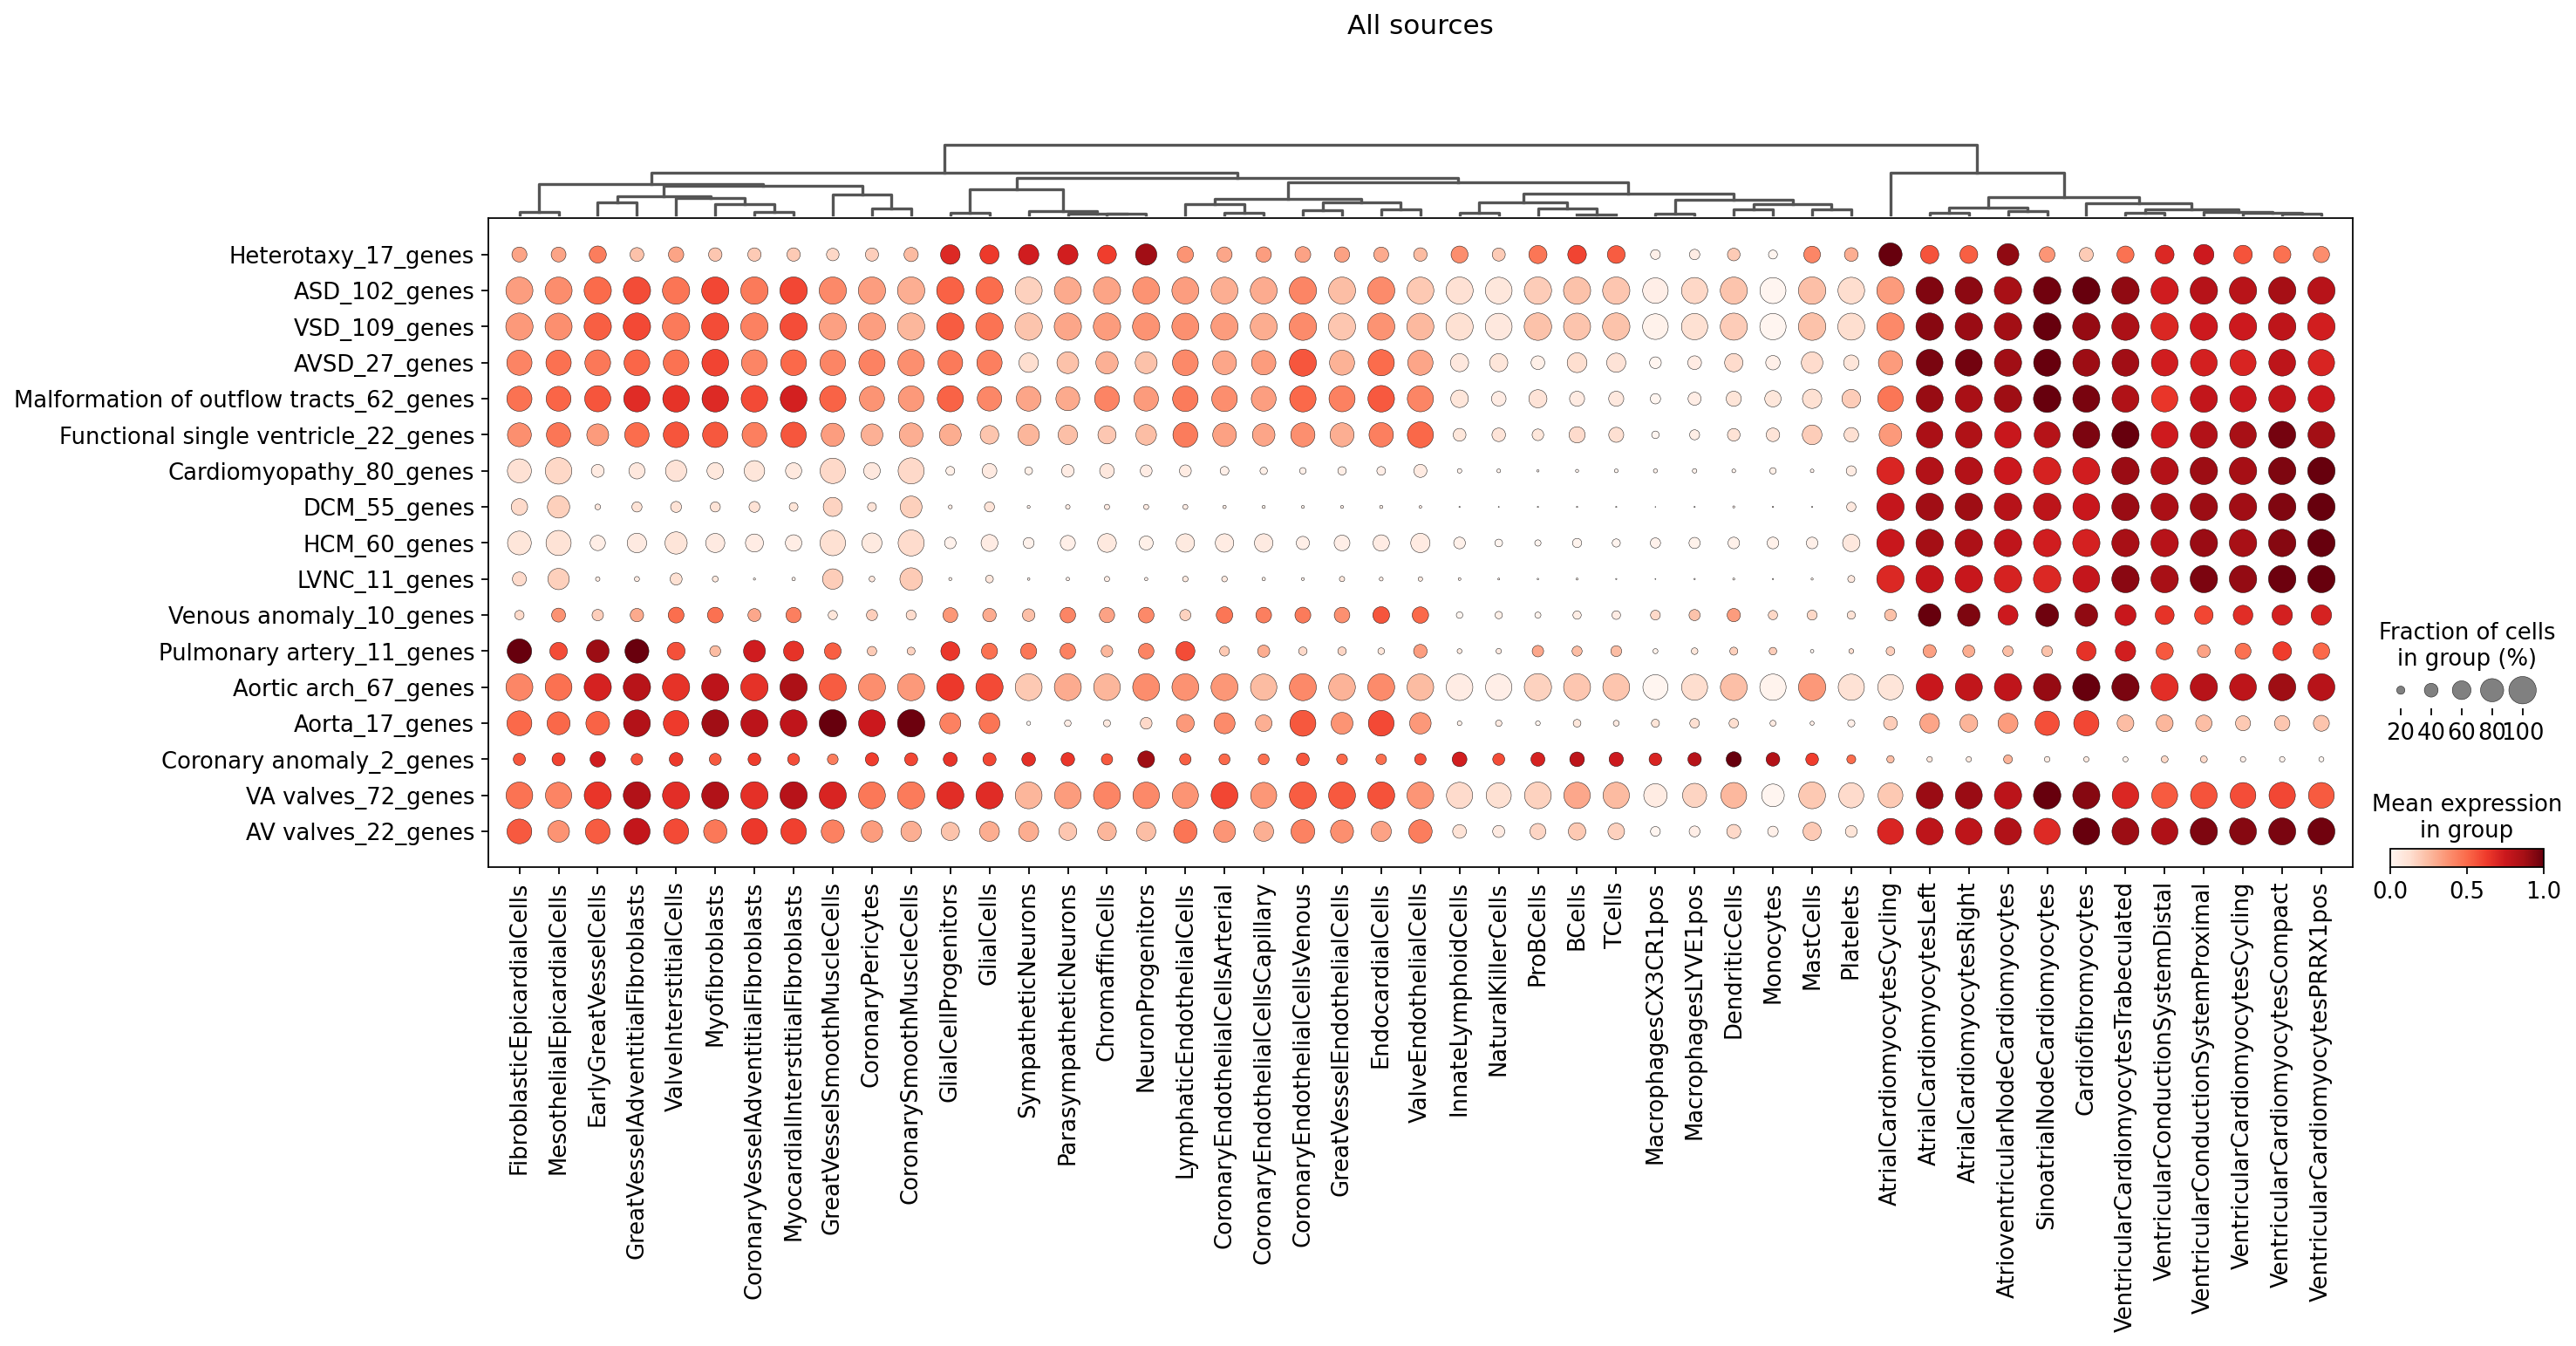

CPU times: user 1min 36s, sys: 29.9 s, total: 2min 6s
Wall time: 2min 6s


In [92]:
%%time
list_of_scores=[]

phenotype_column='PhenotypeList'

for phenotype in range(len(phenotype_dict)):
    gene_list=df.index[df['phenotype_'+str(list(phenotype_dict.keys())[phenotype])]==1].unique().tolist()
    if len(gene_list)>0:
        sc.tl.score_genes(adata,
                          gene_list=gene_list,
                          score_name=str(list(phenotype_dict.keys())[phenotype])+'_'+str(len(gene_list))+'_genes'
                         )
        list_of_scores.append(str(list(phenotype_dict.keys())[phenotype])+'_'+str(len(gene_list))+'_genes')

#Plot all scores
sc.pl.dotplot(adata,
              groupby='fine_grain',
              var_names = list_of_scores,
              standard_scale='var',
              dendrogram=True,
              swap_axes=True,
             title='All sources')

del list_of_scores

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.uniq

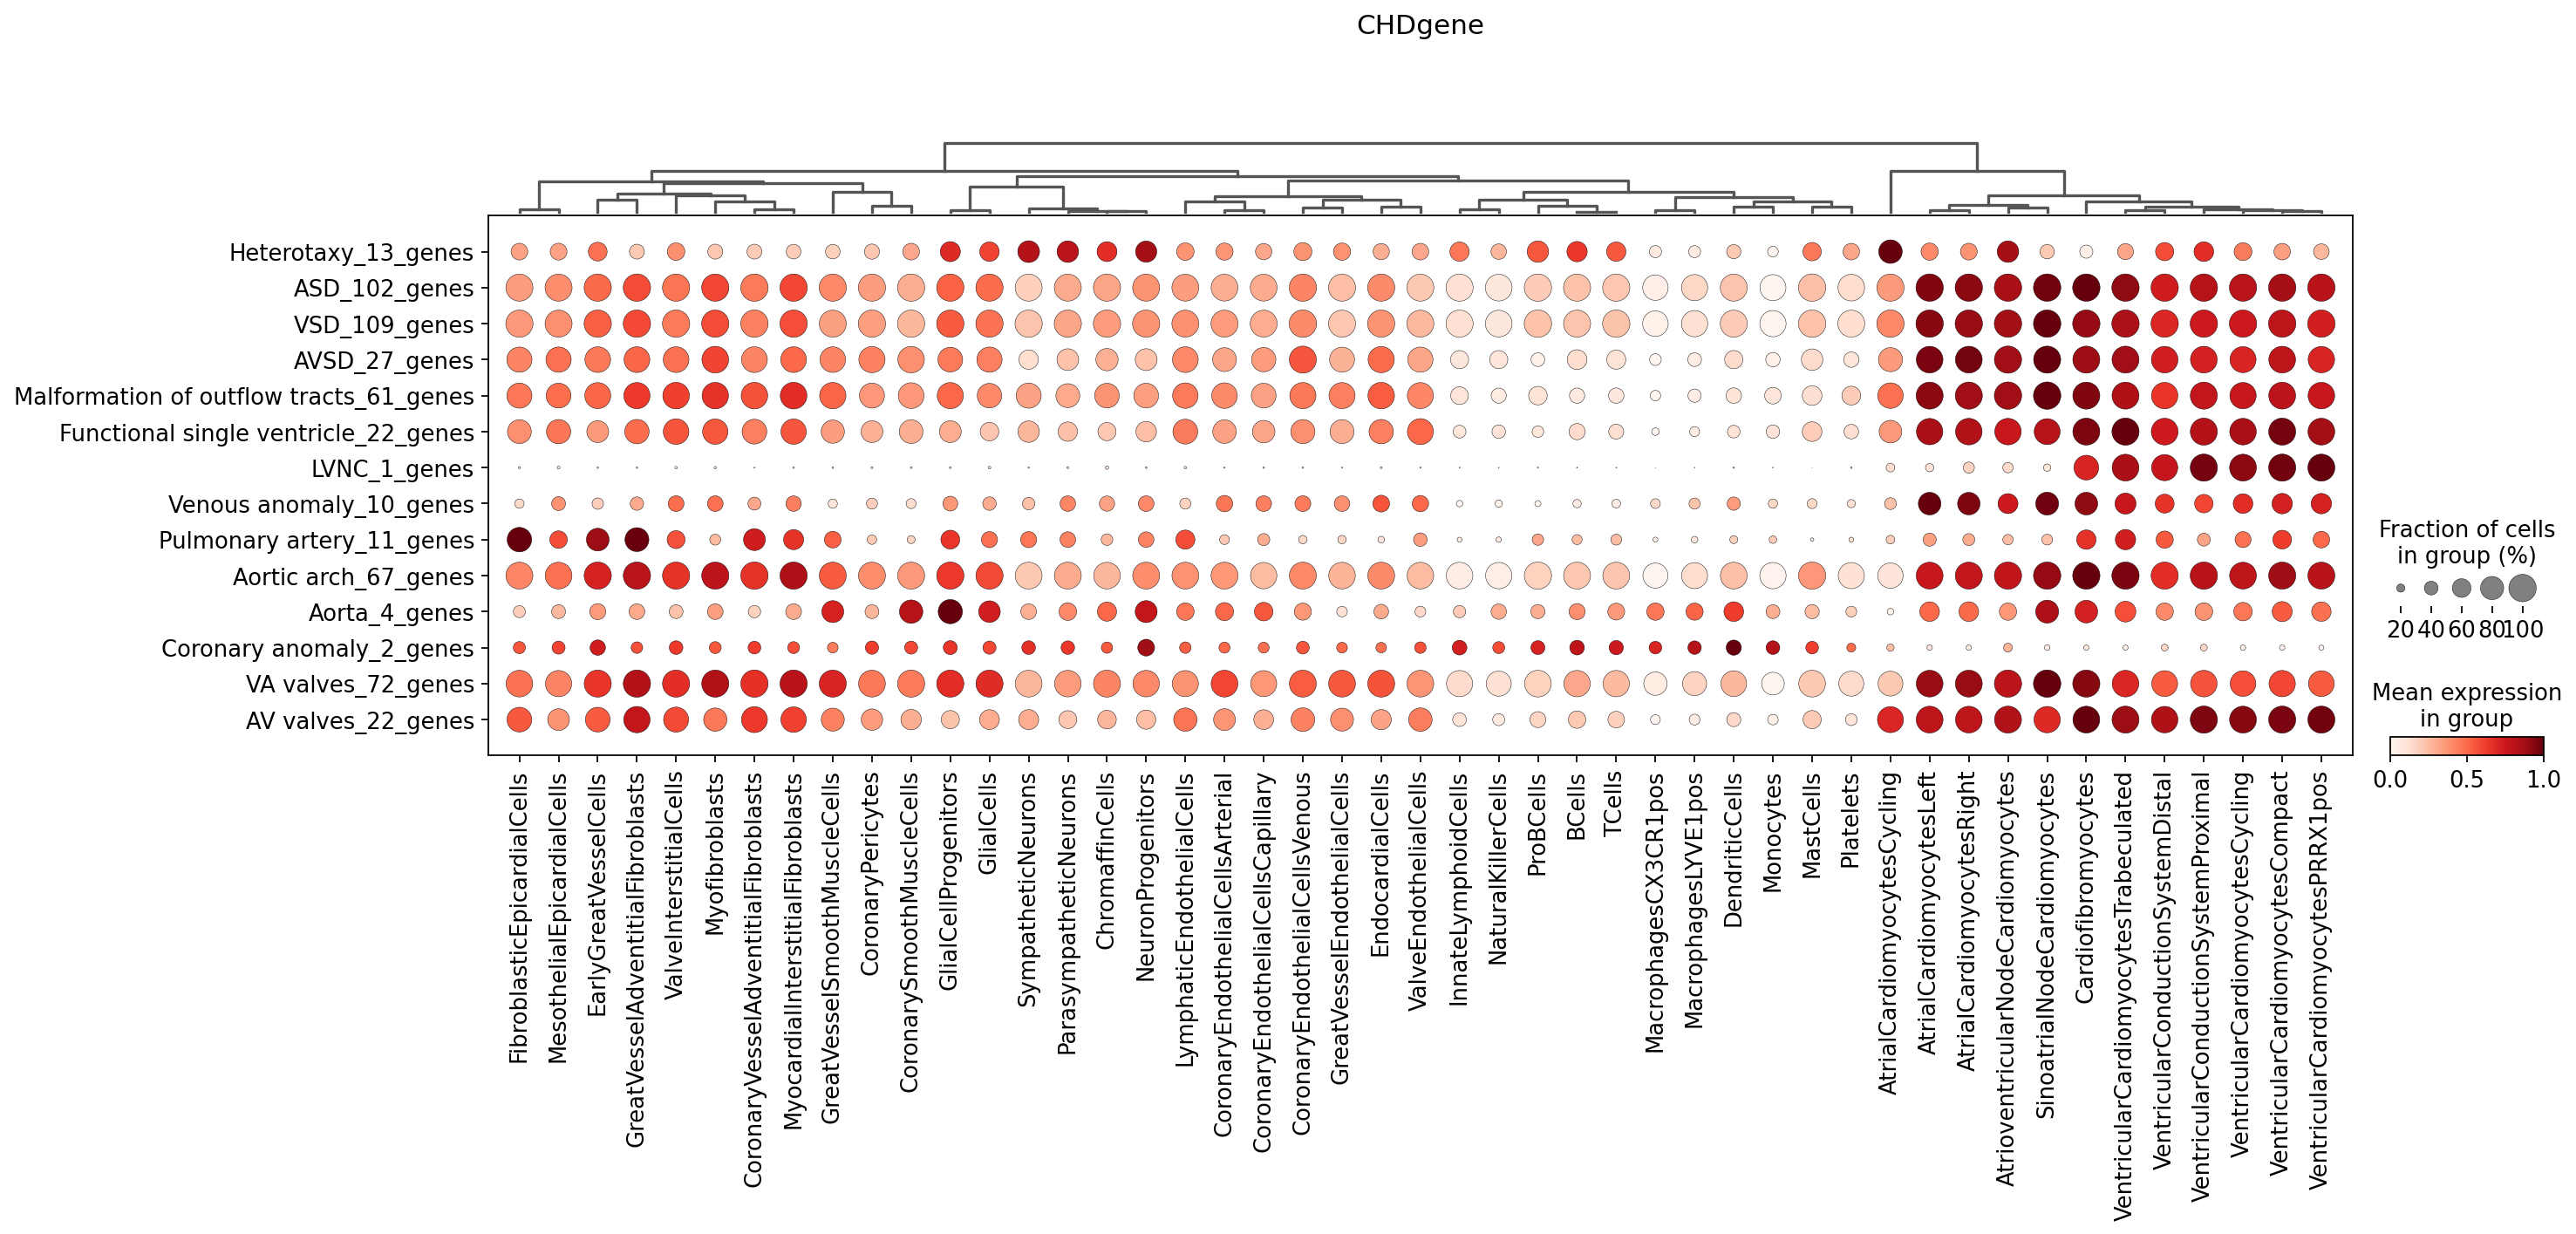

CPU times: user 1min 19s, sys: 23.3 s, total: 1min 42s
Wall time: 1min 42s


In [93]:
%%time
list_of_scores=[]

phenotype_column='PhenotypeList'

subset_by='CHDgene'
tmp=df[df['source']==subset_by]

for phenotype in range(len(phenotype_dict)):
    gene_list=tmp.index[tmp['phenotype_'+str(list(phenotype_dict.keys())[phenotype])]==1].unique().tolist()
    if len(gene_list)>0:
        sc.tl.score_genes(adata,
                          gene_list=gene_list,
                          score_name=str(list(phenotype_dict.keys())[phenotype])+'_'+str(len(gene_list))+'_genes'
                         )
        list_of_scores.append(str(list(phenotype_dict.keys())[phenotype])+'_'+str(len(gene_list))+'_genes')

#Plot all scores
sc.pl.dotplot(adata,
              groupby='fine_grain',
              var_names = list_of_scores,
              standard_scale='var',
              dendrogram=True,
              swap_axes=True,
             title=subset_by)

del list_of_scores

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.uniq

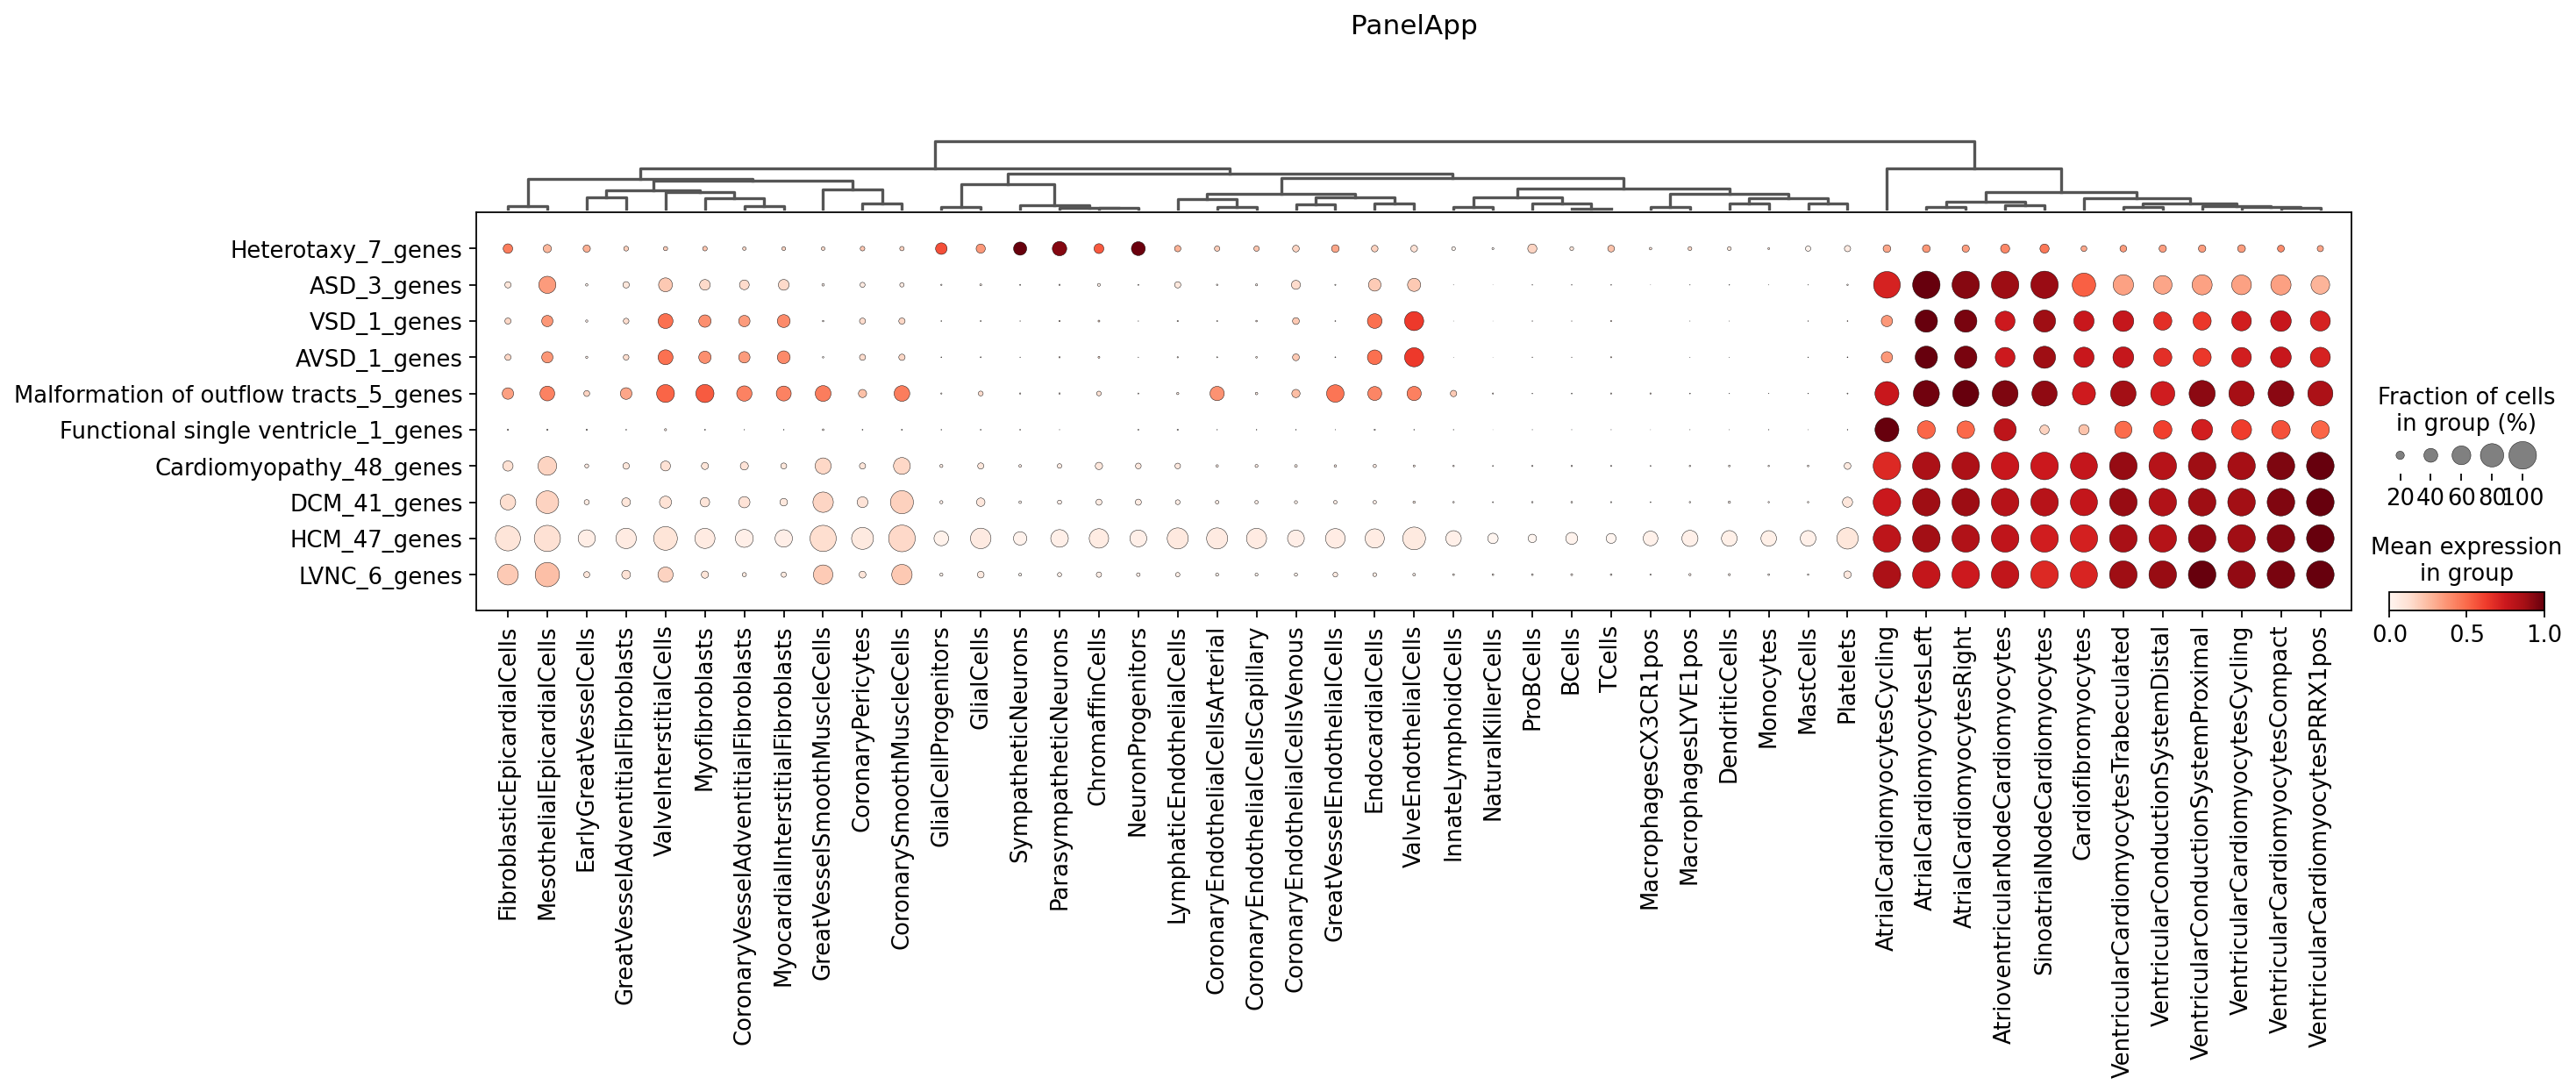

CPU times: user 55.1 s, sys: 17.2 s, total: 1min 12s
Wall time: 1min 12s


In [94]:
%%time
list_of_scores=[]

phenotype_column='PhenotypeList'

subset_by='PanelApp'
tmp=df[df['source']==subset_by]

for phenotype in range(len(phenotype_dict)):
    gene_list=tmp.index[tmp['phenotype_'+str(list(phenotype_dict.keys())[phenotype])]==1].unique().tolist()
    if len(gene_list)>0:
        sc.tl.score_genes(adata,
                          gene_list=gene_list,
                          score_name=str(list(phenotype_dict.keys())[phenotype])+'_'+str(len(gene_list))+'_genes'
                         )
        list_of_scores.append(str(list(phenotype_dict.keys())[phenotype])+'_'+str(len(gene_list))+'_genes')

#Plot all scores
sc.pl.dotplot(adata,
              groupby='fine_grain',
              var_names = list_of_scores,
              standard_scale='var',
              dendrogram=True,
              swap_axes=True,
             title=subset_by)

del list_of_scores

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.uniq

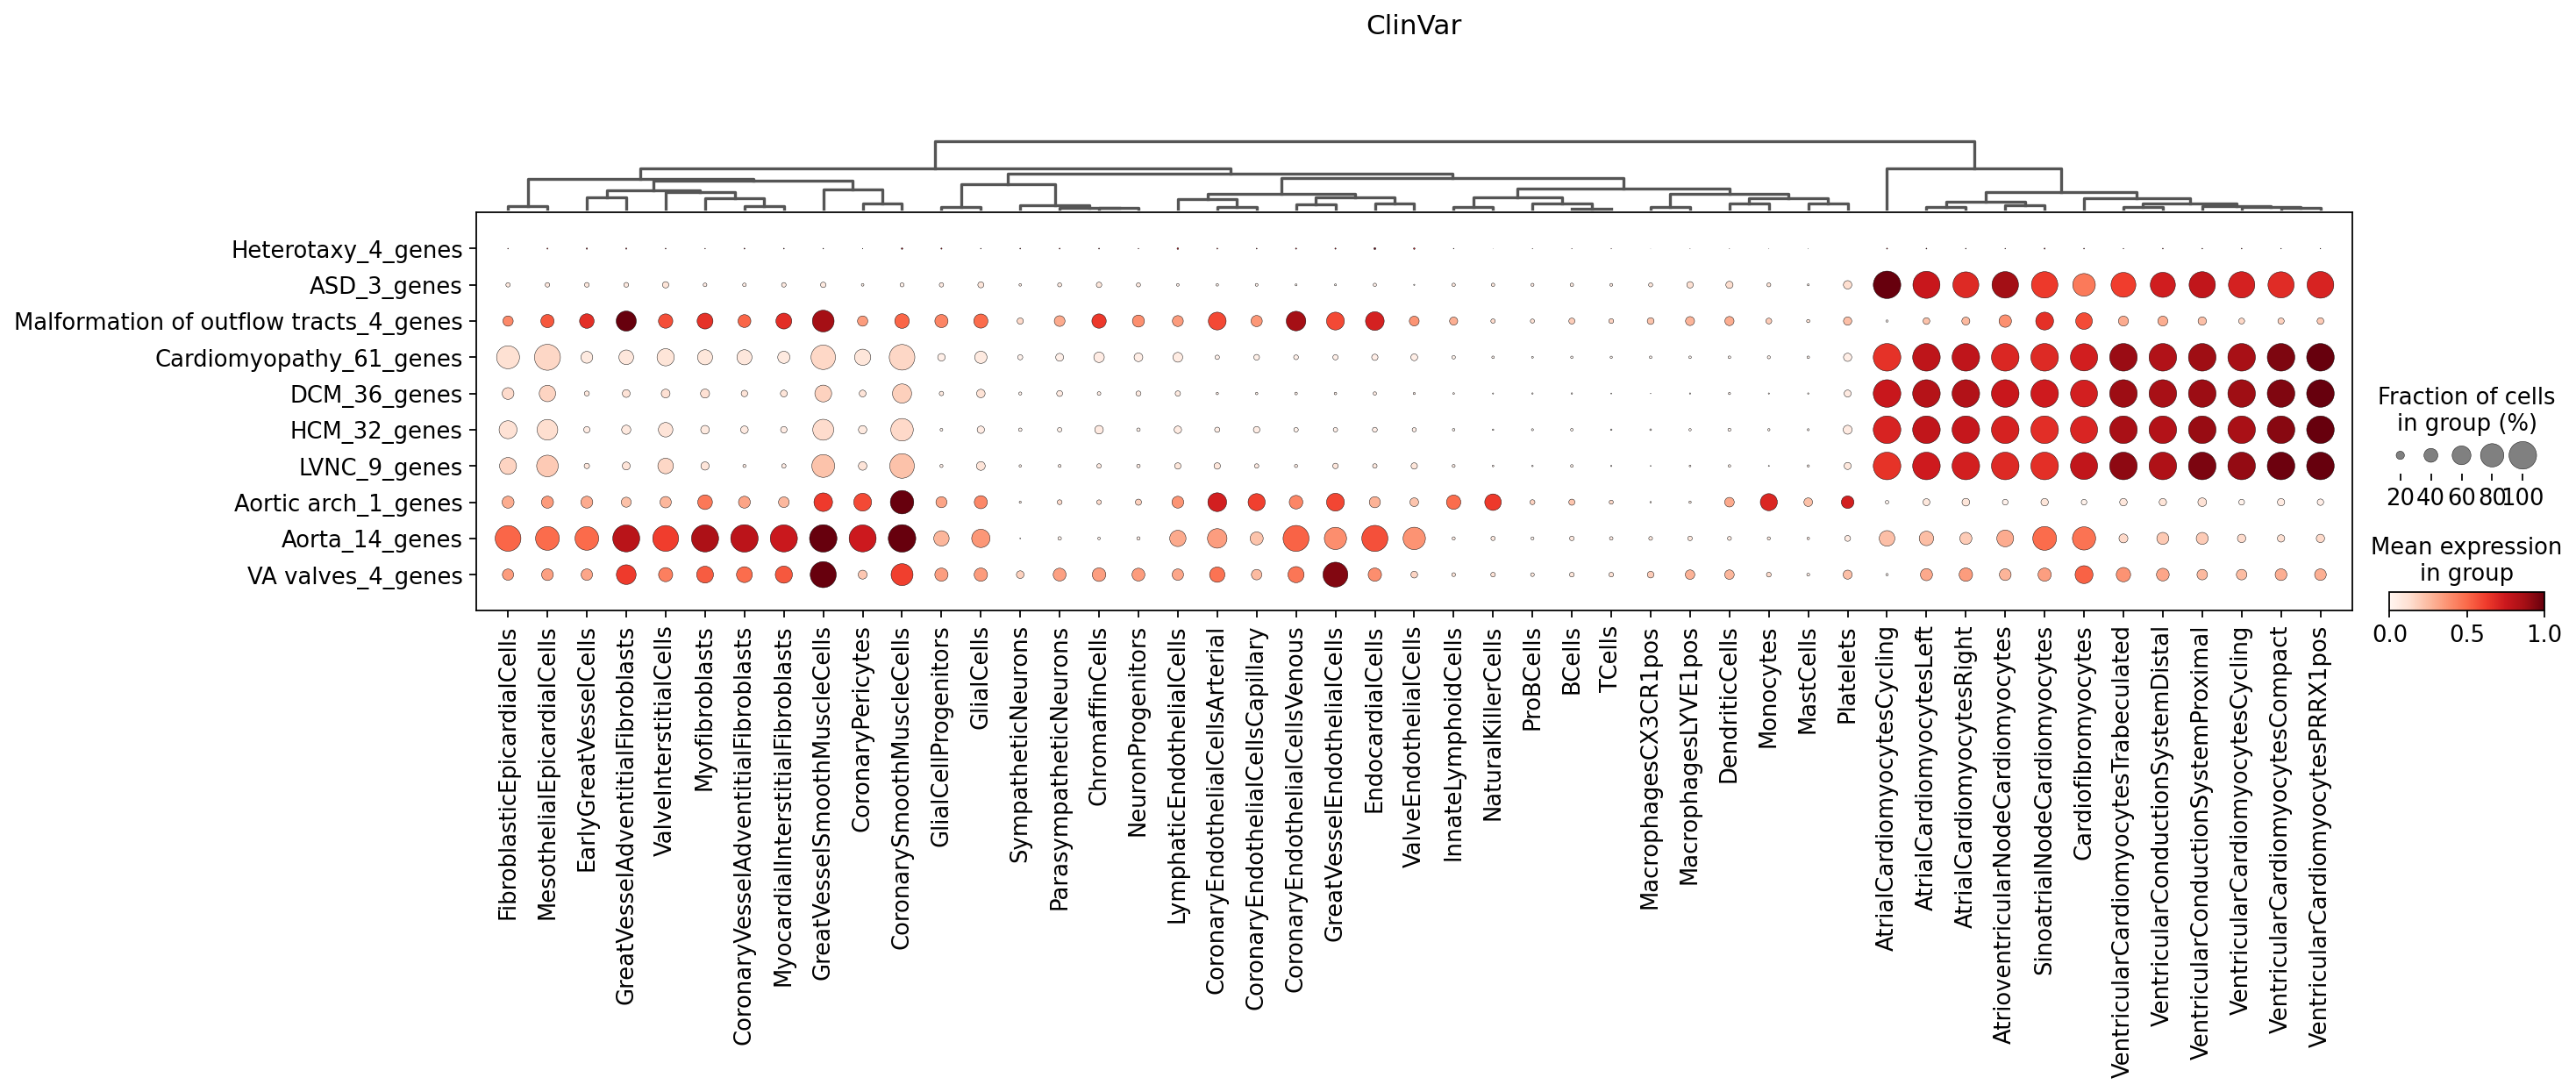

CPU times: user 57.8 s, sys: 21.7 s, total: 1min 19s
Wall time: 1min 19s


In [95]:
%%time
list_of_scores=[]

phenotype_column='PhenotypeList'

subset_by='ClinVar'
tmp=df[df['source']==subset_by]

for phenotype in range(len(phenotype_dict)):
    gene_list=tmp.index[tmp['phenotype_'+str(list(phenotype_dict.keys())[phenotype])]==1].unique().tolist()
    if len(gene_list)>0:
        sc.tl.score_genes(adata,
                          gene_list=gene_list,
                          score_name=str(list(phenotype_dict.keys())[phenotype])+'_'+str(len(gene_list))+'_genes'
                         )
        list_of_scores.append(str(list(phenotype_dict.keys())[phenotype])+'_'+str(len(gene_list))+'_genes')

#Plot all scores
sc.pl.dotplot(adata,
              groupby='fine_grain',
              var_names = list_of_scores,
              standard_scale='var',
              dendrogram=True,
              swap_axes=True,
             title=subset_by)

del list_of_scores